## CNN-LSTM model with Multivariate input
**CNN expects the input data to have the same 3D structure as the LSTM model, although multiple features are read as different channels that ultimately have the same effect (1, num_timestemps, features). 1D CNN is capable of reading across sequence input and automatically learning the salient features.**     
_We can try with univariate input also, where the features will be 1._

## Setting Up Google Colab environment

In [0]:
# Mounting google drive
from google.colab import drive
drive.mount("/content/google_drive/")

In [2]:
# checking if required files are available in my google drive project (I have uploaded my project to google drive)
!ls -R "/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/"

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/':
data  hourly_models  requirements.txt  test_data.csv

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/data':
cleaned_household_power_consumption.csv

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_models':
eval_scaled_48_to_48.npy       model_5
eval_scaled_72_to_48.npy       test_scaled_48_to_48.npy
min_max_all_feat_48_to_48.pkl  test_scaled_72_to_48.npy
min_max_all_feat_72_to_48.pkl  train_scaled_48_to_48.npy
model_4			       train_scaled_72_to_48.npy

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_models/model_4':
last_weights_first_train.h5  model.json		weights_best_train_2.hdf5
last_weights_train_2.h5      weights_best.hdf5

'/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/hourly_m

In [0]:
# change woeking directory to mounted google_drive project directory
import os
google_drive_root = "/content/google_drive/My Drive/Colab Notebooks/individual_household_electric_power_consumption/"
os.chdir(google_drive_root)

In [0]:
# installing requirements
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
# installing requirements
!pip install -r requirements.txt

In [5]:
!nvidia-smi

Tue Oct  8 11:09:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
# Check gpu is available or not
# We need to change runtime type if not changed
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != "/device:GPU:0":
    #raise SystemError('GPU device not found')
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Tensorflow version:  1.14.0
/device:GPU:0
Found GPU at: /device:GPU:0


In [7]:
# My local device
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4866790049473468141, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 803385617223855404
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14577160092348973130
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2829323803687483990
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [8]:
# Checking GPU status
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.6 GB  | Proc size: 442.3 MB
GPU RAM Free: 11372MB | Used: 69MB | Util   1% | Total 11441MB


## Model Building

In [0]:
# coding: utf-8
# !/usr/bin/env python3
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
import joblib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras import optimizers

### Strategy for data preparation will same as model 4.
## Here I will use CNN layer with multivariate inputs to see if the model can do better.
### Scaled Train, Eval, Test is already avalable as numpy file

In [10]:
# load data, Instead of doing all the pre-processing, using the saved numpy arrays
train_scaled = np.load("./hourly_models/train_scaled_72_to_48.npy")
eval_scaled = np.load("./hourly_models/eval_scaled_72_to_48.npy")
test_scaled = np.load("./hourly_models/test_scaled_72_to_48.npy")
print("Training scaled data shape: ", train_scaled.shape)
print("Evaluation scaled data shape: ", eval_scaled.shape)
print("Test scaled data shape: ", test_scaled.shape)

Training scaled data shape:  (33675, 8)
Evaluation scaled data shape:  (792, 8)
Test scaled data shape:  (120, 8)


### Preparing Input & Output:
Unlike Univariate Input, here we are going to provide all 8 features including global active power from last few hours

In [0]:
# slight variation from the univariate function, here I am taking all 8 feature, we can combine both the functions
# by using a flag like univariate = True
def get_X_y(data, n_in, n_out):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_in
        out_end = in_end + n_out
        # ensuring that we have enough data for this instance
        if out_end <= len(data):
            # need only 1 feature
            x_input = data[in_start:in_end, :]
            # it will give [samples, timestemps, features]
            X.append(x_input)
            # [samples, output]
            y_output = data[in_end:out_end, 0]
            y.append(y_output)
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

In [12]:
# Process X and y
n_input = 72
n_output = 48
X_train, y_train = get_X_y(data=train_scaled, n_in=n_input, n_out=n_output)
X_eval, y_eval = get_X_y(data=eval_scaled, n_in=n_input, n_out=n_output)
X_test, y_test = get_X_y(data=test_scaled, n_in=n_input, n_out=n_output)
print("Train X shape: ", X_train.shape)
print("Train y shape: ", y_train.shape)
print("Evaluation X shape: ", X_eval.shape)
print("Evaluation y shape: ", y_eval.shape)
print("Test X shape: ", X_test.shape)
print("Test y shape: ", y_test.shape)

Train X shape:  (33556, 72, 8)
Train y shape:  (33556, 48)
Evaluation X shape:  (673, 72, 8)
Evaluation y shape:  (673, 48)
Test X shape:  (1, 72, 8)
Test y shape:  (1, 48)


In [13]:
# reshape output into [samples, timesteps, features] 
# unlike to the other model this model needs the shape to be 3 dimensional
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
print(y_train.shape)

(33556, 48, 1)


### Build Model

In [16]:
# seeding the random number generation
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)
# defining parameters
learning_rate = 0.001
epochs = 20
batch_size = 64
verbose = 2
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# define model
model = Sequential()
# defining Convolution
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# defining LSTM
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation="relu", return_sequences=True))
model.add(TimeDistributed(Dense(100, activation="relu")))
model.add(TimeDistributed(Dense(1)))
# create optimizer unit to define learning rate
optmzr = optimizers.Adam(lr=learning_rate, clipnorm=1.0)
# compile the model
model.compile(loss="mse", optimizer=optmzr,  metrics=["mse"])
tf.logging.set_verbosity(tf.logging.ERROR)

# model checkpoint
filepath="./hourly_models/model_5/weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=verbose, save_best_only=True, mode="min")
callbacks_list = [checkpoint]

start = datetime.datetime.now()
# Last time validation split was less, increasing (But here again by increasing we are reducing our training data)
model.fit(X_train, y_train, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=verbose)
end = datetime.datetime.now()
print("Model training started at: ", start, " & ended at: ", end)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 28522 samples, validate on 5034 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.00987, saving model to ./hourly_models/model_5/weights_best.hdf5
28522/28522 - 67s - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 2/20

Epoch 00002: val_loss improved from 0.00987 to 0.00827, saving model to ./hourly_models/model_5/weights_best.hdf5
28522/28522 - 64s - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 3/20

Epoch 00003: val_loss improved from 0.00827 to 0.00815, saving model to ./hourly_models/model_5/weights_best.hdf5
28522/28522 - 64s - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 4/20

Epoch 00004: val_loss improved from 0.00815 to 0.00802, saving model to ./hourly_models/model_5/weights_b

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 70, 64)            1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 35, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 1024)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 48, 200)           9

In [0]:
# save model to JSON
model_json = model.to_json()
with open("./hourly_models/model_5/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./hourly_models/model_5/last_weights.h5")

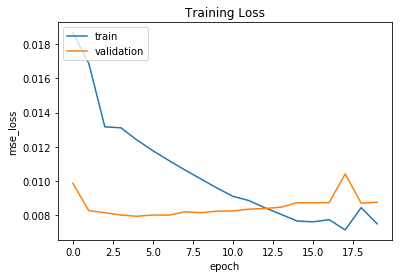

In [19]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Training Loss")
plt.ylabel("mse_loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc='upper left');

In [0]:
# load best weights into the model
model.load_weights("./hourly_models/model_5/weights_best.hdf5")

In [24]:
predictions = []
print("Start: ", datetime.datetime.now())
for arr in X_eval:
    # here array shape is (n_input_timestemps, n_features)
    yhat = model.predict(arr.reshape(1, n_input, 8))
    predictions.append(yhat)
predictions = np.array(predictions)
print("End: ", datetime.datetime.now())

Start:  2019-10-08 11:51:15.912100
End:  2019-10-08 11:51:50.549363


In [25]:
# Prediction is also taking time
print(predictions.shape)
print(y_eval.shape)

(673, 1, 48, 1)
(673, 48)


In [0]:
# load the scalar
scalar = joblib.load("./hourly_models/min_max_all_feat_72_to_48.pkl")

In [0]:
scores = list()
# calculate an RMSE score for each hour
# make the prediction shape as eval shape
pred = predictions.reshape(predictions.shape[0], predictions.shape[2])
#  0th index of scalar values will have details about global_active_power
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
for i in range(y_eval.shape[1]):
    # convert to original scale, we have used MinMaxScalar
    y_eval_inverse = y_eval[:, i] * mult_range + add_min
    pred_inverse = pred[:, i] * mult_range + add_min
    # calculate mse
    mse = mean_squared_error(y_eval_inverse, pred_inverse)
    # calculate rmse
    rmse = np.sqrt(mse)
    # store
    scores.append(rmse)

Text(0, 0.5, 'Prediction Hours')

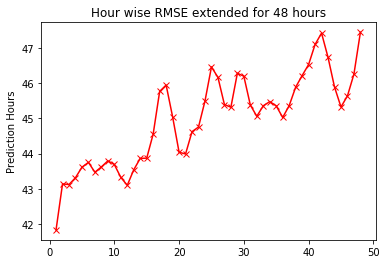

In [31]:
hours = np.arange(1,49)
plt.plot(hours, scores, marker='x', color="r")
plt.title("Hour wise RMSE extended for 48 hours")
plt.ylabel("RMSE global_active_power")
plt.ylabel("Prediction Hours")

### Unlike other models, we can see that prediction are good till moderately longer time than others. The model able to understand region wise importance because of convolution. We can try experimenting with more number of filters & also play around with other parameters.

In [32]:
# Checking overall RMSE
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
overall_mse = mean_squared_error(y_eval.flatten() * mult_range + add_min, pred.flatten() * mult_range + add_min)
overall_rmse = np.sqrt(overall_mse)
print("Overall RMSE for 1 months evaluation period is: {:.2f}".format(overall_rmse))

Overall RMSE for 1 months evaluation period is: 44.99


### Prediction

In [33]:
X_pred, y_pred = X_test, y_test
print("Pred X shape: ", X_pred.shape)
print("Pred y shape (in reality it won't be there): ", y_pred.shape)

Pred X shape:  (1, 72, 8)
Pred y shape (in reality it won't be there):  (1, 48)


In [0]:
# predict for next 48 hours
predictions = []
# looping so that we can have multiple prediction instances
for arr in X_pred:
    # here array shape is (n_input_timestemps, n_features)
    yhat = model.predict(arr.reshape(1, n_input, 8))
    predictions.append(yhat)
predictions = np.array(predictions)

In [0]:
# Convert to original scale
mult_range = scalar.data_range_[0]
add_min = scalar.data_min_[0]
# just looping so that we can generate multiple prediction instance
original_scale_pred = []
for p in predictions:
    inv_scale_pred = p.flatten() * mult_range + add_min
    original_scale_pred.append(inv_scale_pred)

In [0]:
# Create a dataframe to share this (any other way)
df = pd.DataFrame({"local_time": pd.date_range(start="2010-11-24 21:00:00", end="2010-11-26 20:00:00", freq="H"), 
                   "global_active_power": original_scale_pred[0]})
df.set_index("local_time", inplace=True)

In [37]:
df.head()

,global_active_power
local_time,
2010-11-24 21:00:00,113.858047
2010-11-24 22:00:00,88.920792
2010-11-24 23:00:00,53.739319
2010-11-25 00:00:00,40.958588
2010-11-25 01:00:00,31.335535


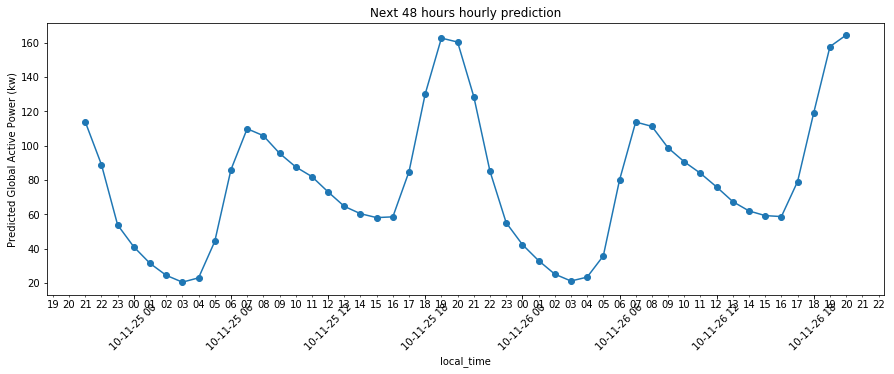

In [38]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.set(xlabel="local_time", ylabel="Predicted Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.xticks(rotation=45);

### Actual vs Prediction

In [0]:
df["actual_global_active_power"] = y_pred.flatten() * mult_range + add_min

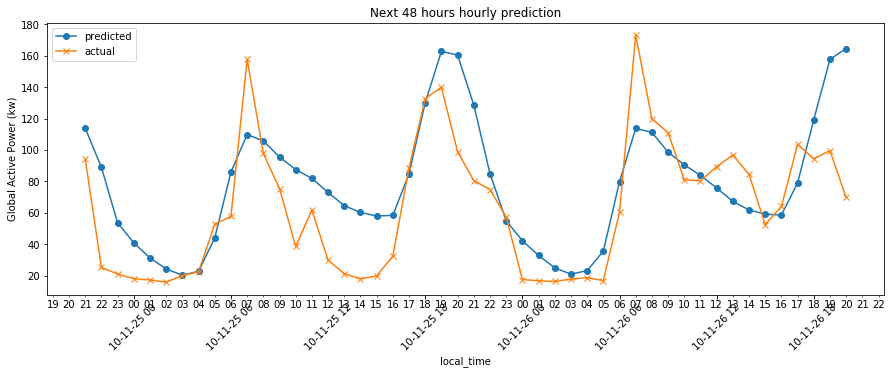

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot("global_active_power", data=df, marker="o")
ax.plot("actual_global_active_power", data=df, marker="x")
ax.set(xlabel="local_time", ylabel="Global Active Power (kw)",
       title="Next 48 hours hourly prediction")
ax.xaxis.set_major_formatter(DateFormatter("%y-%m-%d %H"))
ax.xaxis.set_minor_locator(HourLocator())
ax.xaxis.set_minor_formatter(DateFormatter("%H"))
plt.legend(["predicted", "actual"], loc='upper left')
plt.xticks(rotation=45);

### Here we can see that model able to learn internal representation between features because of convolution layer. If we can provide better features, model will learn better.